In [93]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

BATCH_SIZE = 64
LR = 0.1                   
EPSILON = 0.1               
GAMMA = 0.999                 
TARGET_REPLACE_ITER = 100   
MEMORY_CAPACITY = 2000     
env = gym.make('MountainCar-v0').unwrapped   
N_ACTIONS = env.action_space.n  
N_STATES = env.observation_space.shape[0] 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [94]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 10)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(10, 10)
        self.fc2.weight.data.normal_(0, 0.1)
        self.out = nn.Linear(10, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)

        actions_value = self.out(x)
        return actions_value

In [95]:
class DQN(object):
    def __init__(self):
        self.predict_net, self.target_net = Net(), Net()
        self.target_cnt = 0     
        self.memory_cnt = 0         
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     
        self.optimizer = torch.optim.Adagrad(self.predict_net.parameters(), lr=LR)    
        self.loss_func = nn.MSELoss()   
    
    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        if np.random.rand(1) < EPSILON:
            action = env.action_space.sample()
        else:
            actions_value = self.predict_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()[0]
        return action
        
    def store_transition(self, s, a, r, next_state):
        transition = np.hstack((s, [a, r], next_state))
        index = self.memory_cnt % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_cnt += 1

    def learn(self):
        if self.target_cnt % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.predict_net.state_dict())
        self.target_cnt += 1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        q_predict = self.predict_net(b_s).gather(1, b_a)  
        q_next = self.target_net(b_s_).detach()     
        q_target = b_r + GAMMA * q_next.max(1)[0][0]   
        
        
        loss = self.loss_func(q_predict, q_target)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [96]:
dqn = DQN() 
rAll = []

for i_episode in range(2500):
    s = env.reset()
    r1=0
    for i_step in range(10000):
        a = dqn.choose_action(s)
        next_state, r, done, info = env.step(a)
        dqn.store_transition(s, a, r, next_state)

        if dqn.memory_cnt > MEMORY_CAPACITY:
            dqn.learn() 

        if done:    
            break

        s = next_state
        r1 = r1 + r
        
    rAll.append(r)
    print(r1)

-3629.0
-2791.0
-2695.0
-2591.0
-1814.0
-1294.0
-2005.0
-2600.0
-5199.0
-1592.0
-1295.0
-1920.0
-1293.0
-2480.0
-6314.0
-1706.0
-2981.0
-1479.0
-1513.0
-1909.0
-1401.0
-1819.0
-1243.0
-933.0
-3369.0
-4342.0
-1089.0
-700.0
-714.0
-6010.0
-2598.0
-1384.0
-1579.0
-1504.0
-3702.0
-1596.0
-3603.0
-1206.0
-8399.0
-1293.0
-3931.0
-4465.0
-1303.0
-7974.0
-1071.0
-2251.0
-8692.0
-1307.0
-2501.0
-1085.0
-2909.0
-1943.0
-3358.0
-3185.0
-9511.0
-2086.0
-3407.0
-1708.0
-3175.0
-4409.0
-2595.0
-1765.0
-2647.0
-1603.0
-1281.0
-1200.0
-1514.0
-6887.0
-1403.0
-2323.0
-2289.0
-1564.0
-3226.0
-10000.0
-1993.0
-4106.0
-3893.0
-3807.0
-3693.0
-1698.0
-3297.0
-1884.0
-1110.0
-2091.0
-964.0
-2949.0
-2447.0
-2063.0
-1261.0
-1620.0
-2302.0
-2273.0
-1468.0
-852.0
-3114.0
-2897.0
-1291.0
-4037.0
-761.0
-1584.0
-2114.0
-3465.0
-1128.0
-4406.0
-2302.0
-1749.0
-2346.0
-6689.0
-1501.0
-1555.0
-1351.0
-1291.0
-3875.0
-916.0
-3266.0
-4350.0
-3295.0
-2153.0
-1535.0
-1386.0
-3658.0
-851.0
-3941.0
-1395.0
-1127.0
-1140.0

-2643.0
-1973.0
-2641.0
-2736.0
-1104.0
-1469.0
-1059.0
-1434.0
-1215.0
-1362.0
-2805.0
-3514.0
-2539.0
-1898.0
-1500.0
-2902.0
-4486.0
-2259.0
-1197.0
-2184.0
-1903.0
-2210.0
-2934.0
-2596.0
-1153.0
-1694.0
-2862.0
-2921.0
-2981.0
-3007.0
-1714.0
-1474.0
-1878.0
-1545.0
-2206.0
-2834.0
-2376.0
-1490.0
-1172.0
-1942.0
-912.0
-1391.0
-1612.0
-4717.0
-3515.0
-3786.0
-2932.0
-1875.0
-1930.0
-1081.0
-1950.0
-2985.0
-1617.0
-1568.0
-1799.0
-2736.0
-2779.0
-2309.0
-1593.0
-2205.0
-1567.0
-1448.0
-2738.0
-1418.0
-1311.0
-4214.0
-2124.0
-2170.0
-1538.0
-1322.0
-989.0
-1827.0
-1451.0
-3113.0
-1176.0
-1631.0
-864.0
-523.0
-1373.0
-1656.0
-2708.0
-1427.0
-1345.0
-2605.0
-1868.0
-989.0
-1711.0
-1862.0
-1041.0
-1259.0
-1552.0
-1611.0
-960.0
-2276.0
-1599.0
-1429.0
-817.0
-1954.0
-980.0
-1646.0
-2188.0
-1245.0
-1506.0
-887.0
-1119.0
-1794.0
-924.0
-1562.0
-1900.0
-1360.0
-1407.0
-1178.0
-2001.0
-2208.0
-2471.0
-2456.0
-2303.0
-1637.0
-1842.0
-1981.0
-950.0
-2583.0
-3354.0
-2624.0
-3022.0
-2673.0
-31

-2162.0
-1900.0
-3270.0
-2347.0
-2197.0
-1678.0
-930.0
-1324.0
-845.0
-1408.0
-1525.0
-1373.0
-1383.0
-1344.0
-2498.0
-1191.0
-1445.0
-939.0
-1118.0
-2852.0
-2882.0
-2684.0
-1659.0
-1310.0
-1164.0
-3104.0
-3175.0
-2175.0
-984.0
-3183.0
-2849.0
-1875.0
-1039.0
-960.0
-1206.0
-1747.0
-1740.0
-1426.0
-1395.0
-1462.0
-1082.0
-1575.0
-557.0
-2001.0
-864.0
-1796.0
-1634.0
-1540.0
-2879.0
-1612.0
-881.0
-5416.0
-1331.0
-1188.0
-1343.0
-1261.0
-2259.0
-1712.0
-1243.0
-882.0
-2486.0
-1506.0
-1167.0
-1185.0
-2075.0
-1906.0
-874.0
-2367.0
-1546.0
-1732.0
-755.0
-2391.0
-1516.0
-1371.0
-918.0
-1247.0
-1074.0
-1546.0
-1874.0
-1506.0
-1215.0
-1334.0
-1345.0
-1510.0
-914.0
-1294.0
-1244.0
-1180.0
-1765.0
-968.0
-2803.0
-1378.0
-2901.0
-1771.0
-1076.0
-2876.0
-2406.0
-1065.0
-1550.0
-2726.0
-2406.0
-941.0
-1089.0
-1750.0
-1931.0
-872.0
-2360.0
-1553.0
-1004.0
-1388.0
-1381.0
-969.0
-1015.0
-1990.0
-969.0
-1589.0
-1648.0
-2434.0
-1723.0
-810.0
-1348.0
-2035.0
-1242.0
-1623.0
-937.0
-1460.0
-1542.0
-142

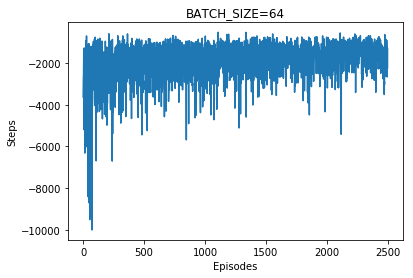

In [100]:
import pandas as pd
df = pd.read_excel(r"C:\Users\user\Desktop\123.xlsx")
values = df['rALL1'].values
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(2500)
line = plt.plot(x, values[:])
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.title('BATCH_SIZE=64')
plt.show()